In [5]:
pip install tf_models_official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 71.7 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=fe78becafccc8031ebd35de707d5c87a8f4027385f49cdc39fb57a90aed94d01
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [6]:
%matplotlib inline
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [7]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [8]:
batch_size=32
glue, info = tfds.load('glue/mrpc',
                       with_info=True,
                       batch_size=32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3668 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mrpc/2.0.0.incompleteEQR0R5/glue-train.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/408 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mrpc/2.0.0.incompleteEQR0R5/glue-validation.tfrecord*...:   0%|      …

Generating test examples...:   0%|          | 0/1725 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/mrpc/2.0.0.incompleteEQR0R5/glue-test.tfrecord*...:   0%|          | …

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/2.0.0. Subsequent calls will reuse this data.


In [9]:
glue

{Split('train'): <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>,
 Split('validation'): <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>,
 Split('test'): <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>}

In [10]:
info.features

FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=string),
    'sentence2': Text(shape=(), dtype=string),
})

In [11]:
info.features['label'].names

['not_equivalent', 'equivalent']

In [12]:
example_batch = next(iter(glue['train']))

for key, value in example_batch.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


In [13]:
tokenizer = tfm.nlp.layers.FastWordpieceBertTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
    lower_case=True)

In [14]:
tokens = tokenizer(tf.constant(["Hello TensorFlow!"]))
tokens

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>

In [15]:
special = tokenizer.get_special_tokens_dict()
special

{'vocab_size': 30522,
 'start_of_sequence_id': 101,
 'end_of_segment_id': 102,
 'padding_id': 0,
 'mask_id': 103}

In [16]:
max_seq_length = 128

packer = tfm.nlp.layers.BertPackInputs(
    seq_length=max_seq_length,
    special_tokens_dict = tokenizer.get_special_tokens_dict())

In [17]:
sentences1 = ["hello tensorflow"]
tok1 = tokenizer(sentences1)
tok1

<tf.RaggedTensor [[[7592], [23435, 12314]]]>

In [18]:
sentences2 = ["goodbye tensorflow"]
tok2 = tokenizer(sentences2)
tok2

<tf.RaggedTensor [[[9119], [23435, 12314]]]>

In [19]:
class BertInputProcessor(tf.keras.layers.Layer):
  def __init__(self, tokenizer, packer):
    super().__init__()
    self.tokenizer = tokenizer
    self.packer = packer

  def call(self, inputs):
    tok1 = self.tokenizer(inputs['sentence1'])
    tok2 = self.tokenizer(inputs['sentence2'])

    packed = self.packer([tok1, tok2])

    if 'label' in inputs:
      return packed, inputs['label']
    else:
      return packed

In [20]:
bert_inputs_processor = BertInputProcessor(tokenizer, packer)

In [21]:
glue_train = glue['train'].map(bert_inputs_processor).prefetch(1)

In [22]:
example_inputs, example_labels = next(iter(glue_train))

In [23]:
example_inputs

{'input_word_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[ 101, 1996, 7235, ...,    0,    0,    0],
        [ 101, 2625, 2084, ...,    0,    0,    0],
        [ 101, 6804, 1011, ...,    0,    0,    0],
        ...,
        [ 101, 2021, 2049, ...,    0,    0,    0],
        [ 101, 2274, 2062, ...,    0,    0,    0],
        [ 101, 2043, 1037, ...,    0,    0,    0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}

In [24]:
example_labels

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1])>

In [25]:
for key, value in example_inputs.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'{"labels":15s} shape: {example_labels.shape}')

input_word_ids  shape: (32, 128)
input_mask      shape: (32, 128)
input_type_ids  shape: (32, 128)
labels          shape: (32,)


In [26]:
plt.pcolormesh(example_inputs['input_word_ids'])
plt.show()

In [27]:
plt.pcolormesh(example_inputs['input_mask'])

In [28]:
plt.pcolormesh(example_inputs['input_type_ids'])

In [29]:
glue_validation = glue['validation'].map(bert_inputs_processor).prefetch(1)
glue_test = glue['test'].map(bert_inputs_processor).prefetch(1)

In [30]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [31]:
encoder_config = tfm.nlp.encoders.EncoderConfig({
    'type':'bert',
    'bert': config_dict
})

In [32]:
bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)
bert_encoder

In [33]:
bert_classifier = tfm.nlp.models.BertClassifier(network=bert_encoder, num_classes=2)

In [34]:
bert_classifier(
    example_inputs, training=True).numpy()[:10]

array([[-0.16681525, -0.16525394],
       [ 0.15812066, -0.34145778],
       [-0.36110452,  0.2162556 ],
       [ 0.01582581,  0.15360796],
       [ 0.35551384, -0.6811322 ],
       [-0.95432866, -0.00948352],
       [ 0.06068915,  0.21827805],
       [ 0.18051174, -0.17313716],
       [-0.40445596,  0.27588153],
       [ 0.02480078, -0.15127291]], dtype=float32)

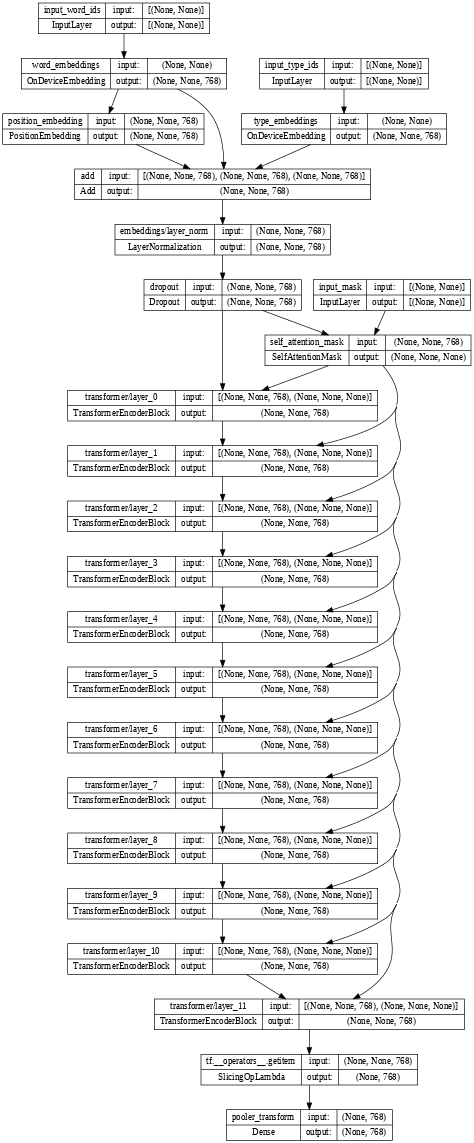

In [35]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [36]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [37]:
# Set up epochs and steps
epochs = 5
batch_size = 32
eval_batch_size = 32

train_data_size = info.splits['train'].num_examples
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-5

In [38]:
linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)

In [39]:
warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = warmup_steps
)

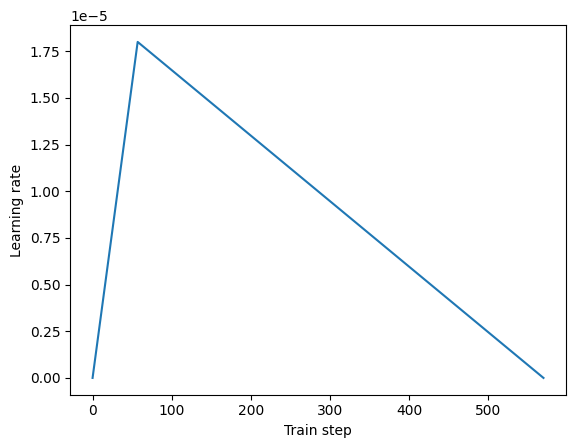

In [43]:
%matplotlib inline
x = tf.linspace(0, num_train_steps, 1001)
y = [warmup_schedule(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')
plt.show()

In [41]:
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

In [42]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

In [47]:
bert_classifier.evaluate(glue_validation)

13/13 [==============================] - 4s 255ms/step - loss: 0.6671 - accuracy: 0.6838


[0.6671088933944702, 0.6838235259056091]

In [48]:
history = bert_classifier.fit(
      glue_train,
      validation_data=(glue_validation),
      batch_size=32,
      epochs=epochs)

Epoch 1/5
115/115 [==============================] - 130s 801ms/step - loss: 0.6227 - accuracy: 0.6698 - val_loss: 0.5057 - val_accuracy: 0.7696
Epoch 2/5
115/115 [==============================] - 94s 817ms/step - loss: 0.4256 - accuracy: 0.8059 - val_loss: 0.3793 - val_accuracy: 0.8284
Epoch 3/5
115/115 [==============================] - 98s 856ms/step - loss: 0.2489 - accuracy: 0.8989 - val_loss: 0.4003 - val_accuracy: 0.8505
Epoch 4/5
115/115 [==============================] - 95s 825ms/step - loss: 0.1307 - accuracy: 0.9526 - val_loss: 0.4376 - val_accuracy: 0.8676
Epoch 5/5
115/115 [==============================] - 97s 840ms/step - loss: 0.0759 - accuracy: 0.9760 - val_loss: 0.4448 - val_accuracy: 0.8529


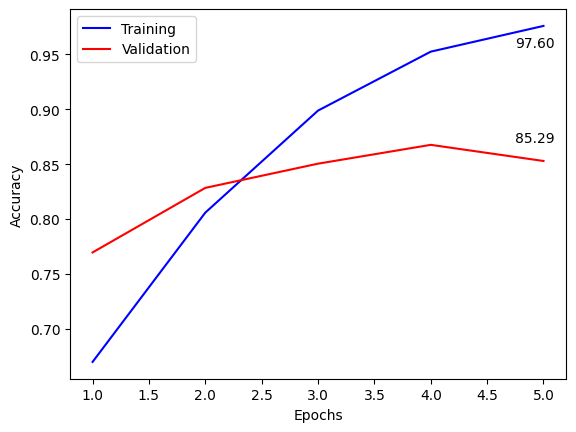

In [59]:
import matplotlib.pyplot as plt

epoch=[1,2,3,4,5]

fig = plt.figure()
plt.plot(epoch, history.history['accuracy'], color='blue', label='Training')
plt.plot(epoch, history.history['val_accuracy'], color='red', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate('%.2f'%(history.history['val_accuracy'][-1]*100), (epoch[-1]*.95,history.history['val_accuracy'][-1]*1.02))
plt.annotate('%.2f'%(history.history['accuracy'][-1]*100), (epoch[-1]*.95,history.history['accuracy'][-1]*.98))
plt.show()

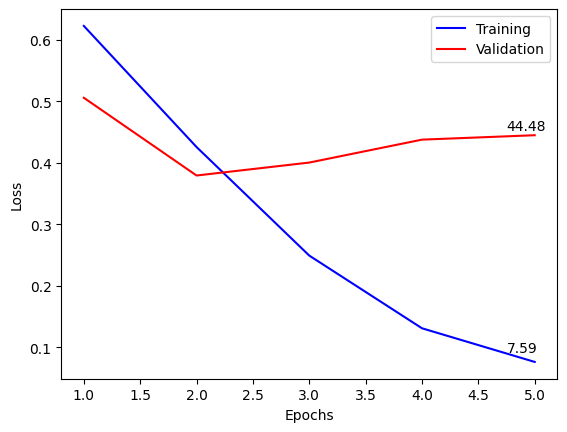

In [60]:
fig = plt.figure()
plt.plot(epoch, history.history['loss'], color='blue', label='Training')
plt.plot(epoch, history.history['val_loss'], color='red', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate('%.2f'%(history.history['val_loss'][-1]*100), (epoch[-1]*.95,history.history['val_loss'][-1]*1.02))
plt.annotate('%.2f'%(history.history['loss'][-1]*100), (epoch[-1]*.95,history.history['loss'][-1]*1.2))
plt.show()

In [51]:
my_examples = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    }

In [52]:
ex_packed = bert_inputs_processor(my_examples)
my_logits = bert_classifier(ex_packed, training=False)

result_cls_ids = tf.argmax(my_logits)
result_cls_ids

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>

In [53]:
tf.gather(tf.constant(info.features['label'].names), result_cls_ids)

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'equivalent', b'not_equivalent'], dtype=object)>